In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore
from disp import set_plot, plot_b, get_line

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

FPCA = f'data/simple/mlv/neur_basic/baker_dyn_pca_nm91_zh23/pca_results.npy'

In [2]:
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

# nonlinear adaptive simulation
tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_ss = np.array(DF_DYN_PARAM['X_S'])
x_ps = np.array(DF_DYN_PARAM['X_P'])

DF_DYN_PARAM

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [3]:
def smlt_ln_(i_s, i_p, h_s, h_p):
    """Simulate linear responses to song inputs."""
    r = DT*(signal.fftconvolve(i_s, h_s)[:len(i_s)] + signal.fftconvolve(i_p, h_p)[:len(i_p)])
    r[r < 0] = 0
    return r

def smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [4]:
# step sine and step pulse
t_step = np.arange(0, 20, DT)
i_step = (t_step < 10).astype(float)
i_0 = np.zeros(len(t_step))

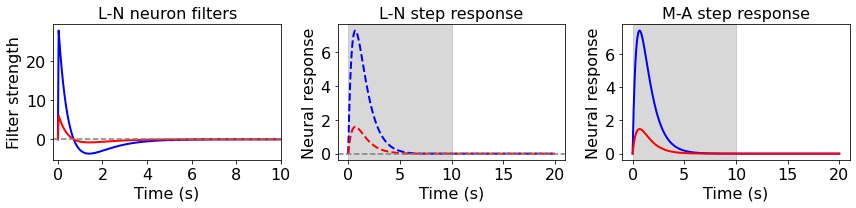

In [5]:
expt_id = 210

tau_r = tau_rs[expt_id]
tau_a = tau_as[expt_id]
x_s = x_ss[expt_id]
x_p = x_ps[expt_id]

h_s = 1.88*cc([[0], np.exp(-t_step[:-1]/.5) - .509*np.exp(-t_step[:-1]/1)])/DT
h_p = h_s/4.6

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
axs[0].plot(t_step, h_s, c='b', lw=2)
axs[0].plot(t_step, h_p, c='r', lw=2)
axs[0].axhline(0, ls='--', color='gray')
# axs[0].legend(['Sine', 'Pulse'])
set_plot(axs[0], x_lim=(-.2, 10), x_label='Time (s)', y_label='Filter strength', title='L-N neuron filters', font_size=16)

axs[1].plot(t_step, smlt_ln_(i_step, i_0, h_s, h_p), c='b', lw=2, ls='--')
axs[1].plot(t_step, smlt_ln_(i_0, i_step, h_s, h_p), c='r', lw=2, ls='--')
axs[1].axvspan(0, 10, color='gray', alpha=.3)
axs[1].axhline(0, color='gray', ls='--')
# axs[1].legend(['Sine', 'Pulse'])
set_plot(axs[1], x_label='Time (s)', y_label='Neural response', title='L-N step response', font_size=16)

axs[2].plot(t_step, smlt_dyn_(i_step, i_0, tau_r, tau_a, x_s, x_p), c='b', lw=2)
axs[2].plot(t_step, smlt_dyn_(i_0, i_step, tau_r, tau_a, x_s, x_p), c='r', lw=2)
# axs[2].plot(t_step, smlt_ln_(i_step, i_0, h_s, h_p), c='b', lw=2, ls='--')
# axs[2].plot(t_step, smlt_ln_(i_0, i_step, h_s, h_p), c='r', lw=2, ls='--')

# axs[2].legend(['Sine', 'Pulse'])
set_plot(axs[2], x_label='Time (s)', y_label='Neural response', title='M-A step response', font_size=16)
axs[2].axvspan(0, 10, color='gray', alpha=.3)

fig.savefig('cosyne_2022/ln_vs_dyn_example.svg')

In [6]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [7]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [8]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [9]:
from aux import get_seg
# get snippets
nt = int(round(10*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sng_s = np.zeros(len(t))
sng_s[t < 10] = 1
sng_p = np.zeros(len(t))
sng_p[t < 10] = 2

sngs = [sng_s, sng_p]  # song snippets


for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs.extend(segs)
    
sngs = np.array(sngs)[:400]

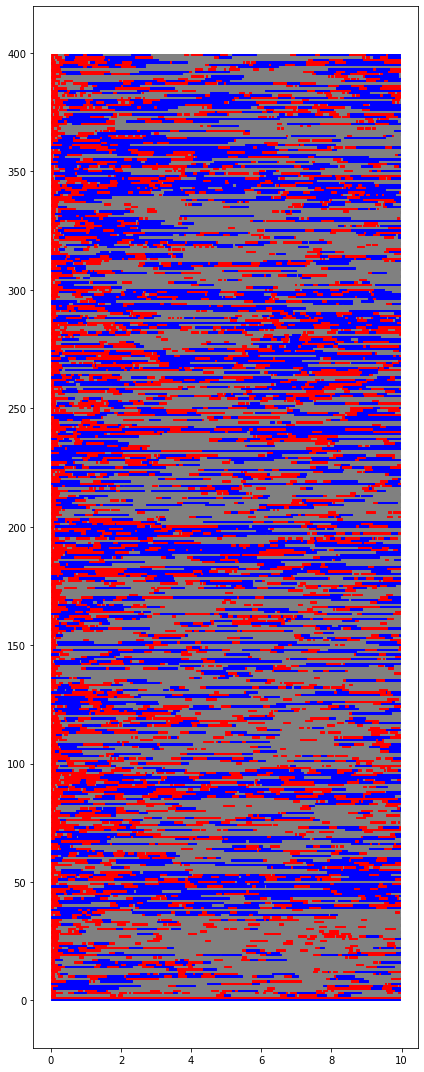

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])

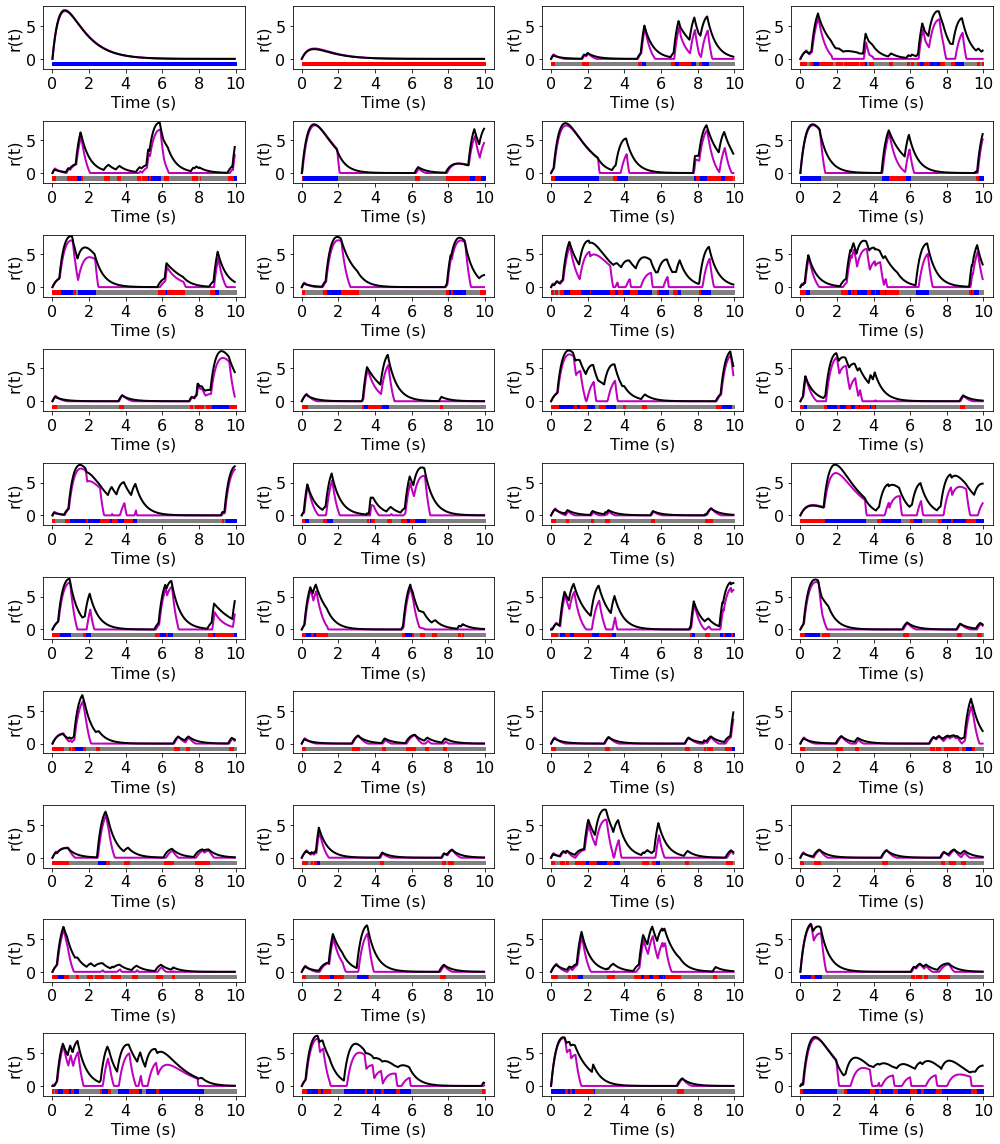

In [11]:
nxpl = 40
fig, axs = plt.subplots(nxpl//4, 4, figsize=(14, nxpl/2.5), tight_layout=True)
for sng, ax in zip(sngs, axs.flatten()):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_ln = smlt_ln_(i_s, i_p, h_s, h_p)
    r_dyn = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    
    ax.plot(t, r_ln, c='m', lw=2)
    ax.plot(t, r_dyn, c='k', lw=2)
    
    plot_b(ax, t, sng, [0, 10, -1, -.5], c=['gray', 'b', 'r'])
    
    ax.set_ylim(-1.5, 8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neural response')
    
    set_plot(ax, y_lim=(-1.5, 8), x_label='Time (s)', y_label='r(t)', font_size=16)
    
fig.savefig('cosyne_2022/ln_vs_dyn_single_neuron_response_short.svg')

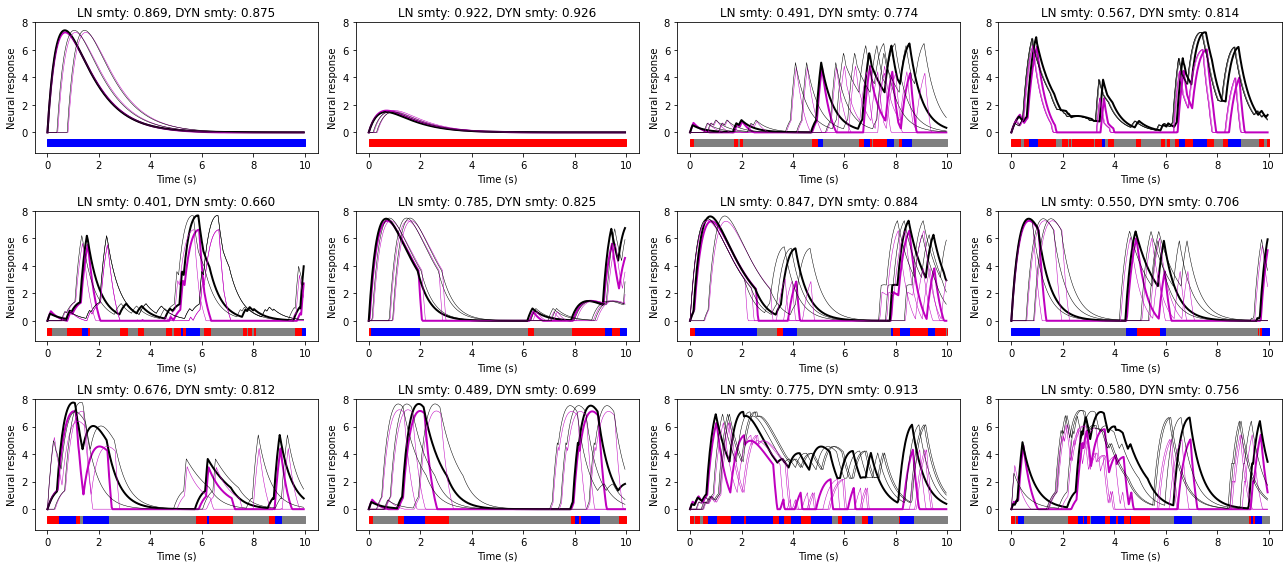

In [19]:
# compute neural response invariance of each model to randomly jittered song
njitters = 30
rjitter = [int(round(-1/DT)), int(round(1/DT))]
nxpl = 12

fig, axs = plt.subplots(nxpl//4, 4, figsize=(18, nxpl/1.5), tight_layout=True)

rs_ln = []
rs_dyn = []

dots_ln_mn = []
dots_dyn_mn = []

for csng, sng in enumerate(sngs):
    
    if csng < nxpl:
        ax = axs.flatten()[csng]
    
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_ln = smlt_ln_(i_s, i_p, h_s, h_p)
    r_dyn = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    
    if csng < nxpl:
        ax.plot(t, r_ln, c='m', lw=2)
        ax.plot(t, r_dyn, c='k', lw=2)

        plot_b(ax, t, sng, [0, 10, -1, -.5], c=['gray', 'b', 'r'])
        
    rs_ln.append(r_ln.copy())
    rs_dyn.append(r_dyn.copy())
    
    r_ln = r_ln / np.linalg.norm(r_ln)
    r_dyn = r_dyn / np.linalg.norm(r_dyn)
    
    dots_ln = []
    dots_dyn = []
    
    for cjitter in range(njitters):
        
        offset = np.random.randint(*rjitter)
        
        if offset <= 0:
            i_s_jittered = cc([i_s[-offset:], np.repeat(0, np.abs(offset))])
            i_p_jittered = cc([i_p[-offset:], np.repeat(0, np.abs(offset))])
        else:
            i_s_jittered = cc([np.repeat(0, np.abs(offset)), i_s[:-offset]])
            i_p_jittered = cc([np.repeat(0, np.abs(offset)), i_p[:-offset]])
        
        r_jittered_ln = smlt_ln_(i_s_jittered, i_p_jittered, h_s, h_p)
        r_jittered_dyn = smlt_dyn_(i_s_jittered, i_p_jittered, tau_r, tau_a, x_s, x_p)
        
        if cjitter < 3 and csng < nxpl:
            ax.plot(t, r_jittered_ln, c='m', lw=.5)
            ax.plot(t, r_jittered_dyn, c='k', lw=.5)
        
        r_jittered_ln = r_jittered_ln / np.linalg.norm(r_jittered_ln)
        r_jittered_dyn = r_jittered_dyn / np.linalg.norm(r_jittered_dyn)
    
        dots_ln.append(r_ln @ r_jittered_ln)
        dots_dyn.append(r_dyn @ r_jittered_dyn)
        
    dots_ln_mn.append(np.mean(dots_ln))
    dots_dyn_mn.append(np.mean(dots_dyn))
    
    if csng < nxpl:
        ax.set_ylim(-1.5, 8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Neural response')
        ax.set_title(f'LN smty: {np.mean(dots_ln):.3f}, DYN smty: {np.mean(dots_dyn):.3f}')
        
fig.savefig('cosyne_2022/jitter_xpl.svg')

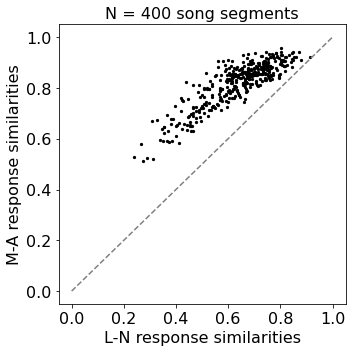

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.scatter(dots_ln_mn[2:], dots_dyn_mn[2:], c='k', s=5)
ax.plot([0, 1], [0, 1], ls='--', c='gray')
ax.set_xlabel('L-N response similarities')
ax.set_ylabel('M-A response similarities')
ax.set_title(f'N = {len(sngs)} song segments')

set_plot(ax, font_size=16)

fig.savefig('cosyne_2022/dyn_vs_ln_response_similarities_jitter.svg')

In [14]:
# get hamming and edit distances between songs
nsng = len(sngs)

sngs_str = [
    ''.join([str(x) for x in sng]) for sng in sngs
]
ds_hm = np.nan * np.zeros((nsng, nsng))  # hamming distance between songs
ds_lv = np.nan * np.zeros((nsng, nsng))  # levenshtein distance between songs


for i in range(nsng):
    for j in range(i+1, nsng):
        d_hm = np.sum(sngs[i] != sngs[j])
        ds_hm[i, j] = d_hm
        
        d_lv = editdistance.eval(sngs_str[i], sngs_str[j])
        ds_lv[i, j] = d_lv
        
ds_hm_flat = ds_hm.flatten()
ds_lv_flat = ds_lv.flatten()

d_hm_min = np.nanmin(ds_hm)
d_hm_max = np.nanmax(ds_hm)

d_lv_min = np.nanmin(ds_lv)
d_lv_max = np.nanmax(ds_lv)

In [15]:
# get distances between neural timecourses
ds_ln = np.nan * np.zeros((nsng, nsng))
ds_dyn = np.nan * np.zeros((nsng, nsng))

for i in range(nsng):
    for j in range(i+1, nsng):
        ds_ln[i, j] = np.sqrt(np.mean((rs_ln[i] - rs_ln[j])**2))
        ds_dyn[i, j] = np.sqrt(np.mean((rs_dyn[i] - rs_dyn[j])**2))

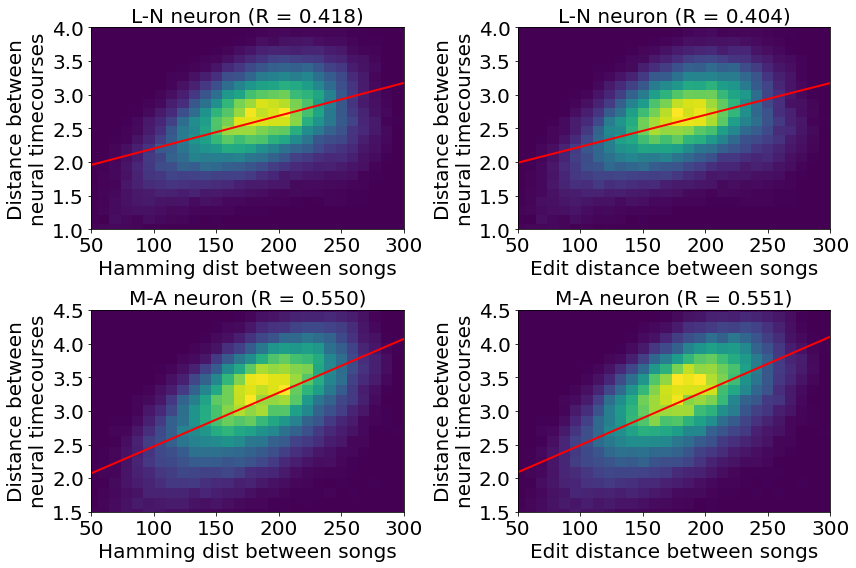

In [16]:
ds_ln_flat = ds_ln.flatten()
ds_dyn_flat = ds_dyn.flatten()

d_ln_min = np.nanmin(ds_ln)
d_ln_max = np.nanmax(ds_ln)

d_dyn_min = np.nanmin(ds_dyn)
d_dyn_max = np.nanmax(ds_dyn)

bins_hm = np.linspace(d_hm_min, d_hm_max, 31)
bins_lv = np.linspace(d_lv_min, d_lv_max, 31)
bins_ln = np.linspace(d_ln_min, d_ln_max, 31)
bins_dyn = np.linspace(d_dyn_min, d_dyn_max, 31)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
axs = axs.flatten()
# axs[0].scatter(ds_hm_flat, ds_ln_flat, c='k', s=5)
axs[0].hist2d(ds_hm_flat, ds_ln_flat, bins=(bins_hm, bins_ln))
x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_hm_flat, ds_ln_flat)
axs[0].plot(x_ln, y_ln, c='r', lw=2)
set_plot(axs[0], x_lim=(50, 300), y_lim=(1, 4), x_label='Hamming dist between songs', y_label='Distance between\nneural timecourses', title=f'L-N neuron (R = {r:.3f})', font_size=20)

# axs[1].scatter(ds_lv_flat, ds_ln_flat, c='k', s=5)
axs[1].hist2d(ds_lv_flat, ds_ln_flat, bins=(bins_lv, bins_ln))
x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_lv_flat, ds_ln_flat)
axs[1].plot(x_ln, y_ln, c='r', lw=2)
set_plot(axs[1], x_lim=(50, 300), y_lim=(1, 4), x_label='Edit distance between songs', y_label='Distance between\nneural timecourses', title=f'L-N neuron (R = {r:.3f})', font_size=20)

# axs[2].scatter(ds_hm_flat, ds_dyn_flat, c='k', s=5)
axs[2].hist2d(ds_hm_flat, ds_dyn_flat, bins=(bins_hm, bins_dyn))
x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_hm_flat, ds_dyn_flat)
axs[2].plot(x_ln, y_ln, c='r', lw=2)
set_plot(axs[2], x_lim=(50, 300), y_lim=(1.5, 4.5), x_label='Hamming dist between songs', y_label='Distance between\nneural timecourses', title=f'M-A neuron (R = {r:.3f})', font_size=20)

# axs[3].scatter(ds_lv_flat, ds_dyn_flat, c='k', s=5)
axs[3].hist2d(ds_lv_flat, ds_dyn_flat, bins=(bins_lv, bins_dyn))
x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(ds_lv_flat, ds_dyn_flat)
axs[3].plot(x_ln, y_ln, c='r', lw=2)
set_plot(axs[3], x_lim=(50, 300), y_lim=(1.5, 4.5), x_label='Edit distance between songs', y_label='Distance between\nneural timecourses', title=f'M-A neuron (R = {r:.3f})', font_size=20)
# set_plot(axs[3], x_label='Edit', y_label='Dyn', title=f'R = {r:.3f}, P = {p:.3f}')

fig.savefig('cosyne_2022/song_vs_neural_dist_xpl.svg')

# Repeat analysis in response to segment warping

In [17]:
def warp(sng, alpha):
    return sng

ValueError: too many values to unpack (expected 2)

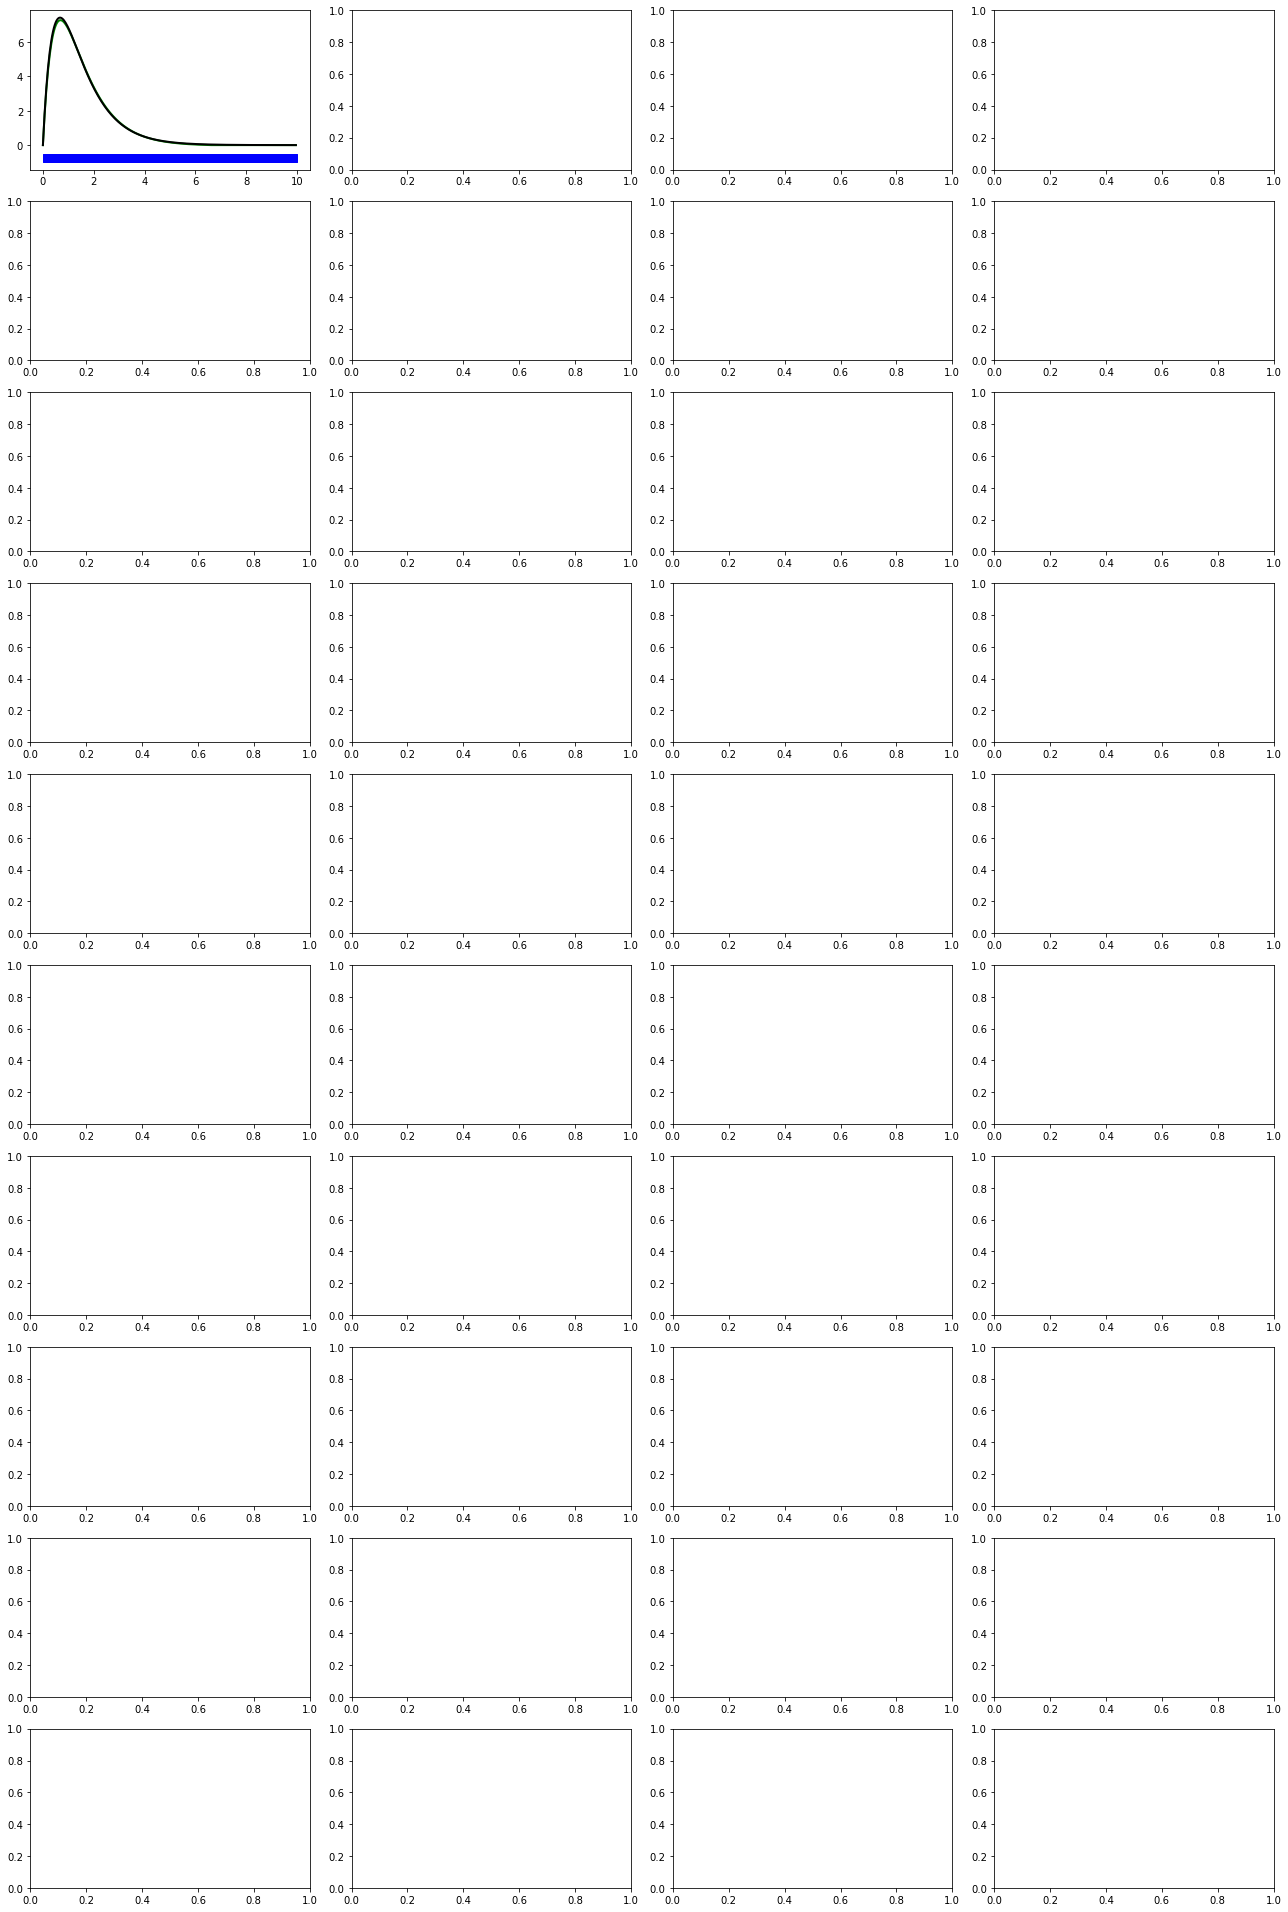

In [18]:
# compute neural response invariance of each model to randomly jittered song
nwarp = 30
nxpl = 40

fig, axs = plt.subplots(nxpl//4, 4, figsize=(18, nxpl/1.5), tight_layout=True)

dots_ln_mn = []
dots_dyn_mn = []

for csng, sng in enumerate(sngs):
    
    if csng < nxpl:
        ax = axs.flatten()[csng]
    
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    r_ln = smlt_ln_(i_s, i_p, h_s, h_p)
    r_dyn = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
    
    if csng < nxpl:
        ax.plot(t, r_ln, c='g', lw=2)
        ax.plot(t, r_dyn, c='k', lw=2)

        plot_b(ax, t, sng, [0, 10, -1, -.5], c=['gray', 'b', 'r'])
        
    r_ln = r_ln / np.linalg.norm(r_ln)
    r_dyn = r_dyn / np.linalg.norm(r_dyn)
    
    dots_ln = []
    dots_dyn = []
    
    for cwarp in range(nwarp):
        
        i_s_warped, i_p_warped = warp(i_s, i_p)
        
        if offset <= 0:
            i_s_jittered = cc([i_s[-offset:], np.repeat(0, np.abs(offset))])
            i_p_jittered = cc([i_p[-offset:], np.repeat(0, np.abs(offset))])
        else:
            i_s_jittered = cc([np.repeat(0, np.abs(offset)), i_s[:-offset]])
            i_p_jittered = cc([np.repeat(0, np.abs(offset)), i_p[:-offset]])
        
        r_jittered_ln = smlt_ln_(i_s_jittered, i_p_jittered, h_s, h_p)
        r_jittered_dyn = smlt_dyn_(i_s_jittered, i_p_jittered, tau_r, tau_a, x_s, x_p)
        
        if cjitter < 3 and csng < nxpl:
            ax.plot(t, r_jittered_ln, c='g', lw=.5)
            ax.plot(t, r_jittered_dyn, c='k', lw=.5)
        
        r_jittered_ln = r_jittered_ln / np.linalg.norm(r_jittered_ln)
        r_jittered_dyn = r_jittered_dyn / np.linalg.norm(r_jittered_dyn)
    
        dots_ln.append(r_ln @ r_jittered_ln)
        dots_dyn.append(r_dyn @ r_jittered_dyn)
        
    dots_ln_mn.append(np.mean(dots_ln))
    dots_dyn_mn.append(np.mean(dots_dyn))
    
    if csng < nxpl:
        ax.set_ylim(-1.5, 8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Neural response')
        ax.set_title(f'LN smty: {np.mean(dots_ln):.3f}, DYN smty: {np.mean(dots_dyn):.3f}')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), tight_layout=True)
ax.scatter(dots_ln_mn[2:], dots_dyn_mn[2:], c='k', s=5)
ax.plot([0, 1], [0, 1], ls='--', c='gray')
ax.set_xlabel('LN response similarities')
ax.set_ylabel('DYN response similarities')
ax.set_title(f'N = {len(sngs)} song segments')

set_plot(ax, font_size=16)